In [1]:
# importing the libraries

import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
from torchsummary import summary

In [24]:
None

In [2]:
#Ref: https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

In [3]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Conv2D, MaxPool2D, Activation, MaxPooling2D, Dropout,AveragePooling2D, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import os

In [4]:
# loading dataset
data = pd.read_csv('lowhead_train.csv')
data.head()


,image_name,lowhead_or_not
0,7-118.png,1
1,8-4.png,1
2,9-1.png,1
3,9-2.png,1
4,9-4.png,1


In [5]:
# loading images
import glob
lowheads_vs_other = glob.glob('lowheadVsother/*.*')

train_img = []
for img_name in tqdm(data['image_name']):
    img_name = 'lowheadVsother/'+img_name
    for i in lowheads_vs_other:
        if(i == img_name):
            image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb')
            image=np.array(image)
            image = image/255
            train_img.append(image)

train_x = np.array(train_img)
train_y = data['lowhead_or_not'].values
train_x.shape, train_y.shape





100%|██████████| 657/657 [00:18<00:00, 35.76it/s]


((657, 500, 500, 3), (657,))

In [6]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)


(((591, 500, 500, 3), (591,)), ((66, 500, 500, 3), (66,)))

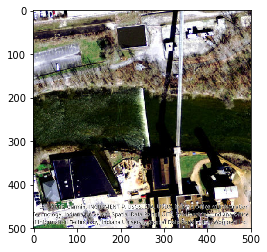

In [7]:
plt.imshow(val_x[64])
    

In [8]:
final_train_data = []
final_target_train = []
for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])
    final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(train_x[i]))
    final_train_data.append(np.flipud(train_x[i]))
    final_train_data.append(random_noise(train_x[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(train_y[i])

100%|██████████| 591/591 [00:52<00:00, 11.17it/s]


1


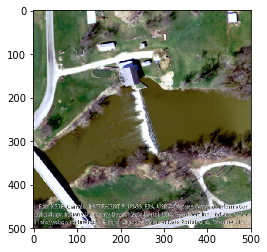

In [9]:
print(final_target_train[5])
plt.imshow(final_train_data[5])


In [10]:
len(final_target_train), len(final_train_data)
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)
print(len(final_target_train))
print(len(final_train_data))

2955
2955


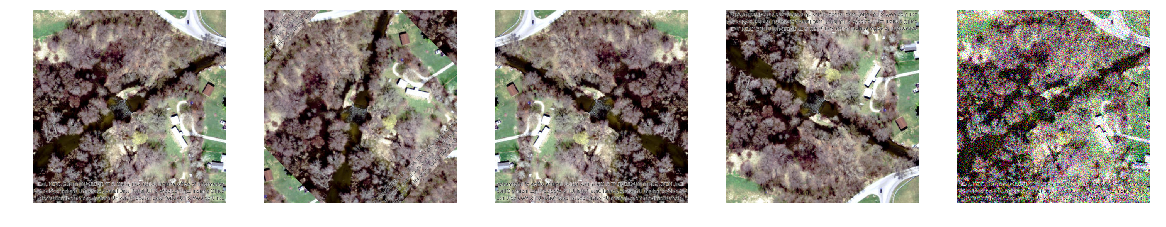

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+20])
    ax[i].axis('off')

In [12]:
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [13]:
# converting training images into torch format
final_train = final_train.reshape(2955, 3, 500, 500)
final_train  = torch.from_numpy(np.asarray(final_train))
final_train = final_train.float()

# converting the target into torch format
final_target_train = final_target_train.astype(int)
final_target_train = torch.from_numpy(final_target_train)

In [14]:
# converting validation images into torch format
val_x = val_x.reshape(66, 3, 500, 500)
val_x  = torch.from_numpy(val_x)
val_x = val_x.float()

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

In [15]:
torch.manual_seed(0)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(123008, 64), #25088
            ReLU(inplace=True),
            Dropout(),
            Linear(64, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [16]:


# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.000075)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available


device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if torch.cuda.is_available():
    model.to(torch.device('cpu:0'))
    criterion = criterion.cpu()

print(model)

Using device: cpu

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=F

In [17]:
#Training the Model

torch.manual_seed(0)

# batch size of the model
batch_size = 64

# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(final_train.size()[0])

    training_loss = []
    for i in tqdm(range(0,final_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_train[indices], final_target_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cpu(), batch_y.cpu()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)
    

100%|██████████| 47/47 [40:47<00:00, 52.07s/it]epoch: 	 20 	 training loss: 	 0.28552833992115995



In [18]:
torch.save(model, 'model.pt')

In [19]:
CNN_model = torch.load('model.pt')

In [20]:
torch.manual_seed(0)
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(final_train.size()[0])
for i in tqdm(range(0,final_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = final_train[indices], final_target_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cpu(), batch_y.cpu()

    with torch.no_grad():
        output = model(batch_x.cpu())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))


100%|██████████| 47/47 [16:46<00:00, 21.42s/it]training accuracy: 	 0.8906854448742746



In [21]:
# checking the performance on validation set
torch.manual_seed(0)
output = model(val_x.cpu())
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(val_y, predictions)






0.7424242424242424

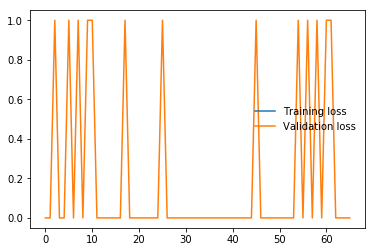

In [23]:
# print(v)
# print(val_x) 


plt.plot(training_loss, label='Training loss')
plt.plot(predictions, label='Validation loss')
plt.legend(frameon=False)
plt.show()
